**IMPORTS**

In [6]:
# Changes AWS to True if on SageMaker Instance and set S3 BUCKET and Key accordingly
AWS = False
BUCKET = 'eu-west-1'
REGION = 'ml-can-ids-logs'

# Import Functions
import setuptools.dist

from importlib import reload
import utils
import anomaly_detection_functions
import feature_selection
import train

reload(utils)
reload(anomaly_detection_functions)
reload(feature_selection)
reload(train)
from utils import plot_loss_curve, plot_pca, plot_tsne, get_confusion_matrix, get_latent_representations_label, analyze_latent_variance, analyze_kl_divergence, linear_annealing, save_results_to_excel, save_trained_model, get_s3_client, check_dataset
from anomaly_detection_functions import get_threshold_from_train, anomaly_detection, get_anomaly_detection_accuracy
from feature_selection import feature_selection_preparation, convert_to_tensorflow
from train import train_model

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, Model
import itertools
import pandas as pd
from datetime import datetime
import warnings
import keras
#from tsfresh import extract_features
#from tsfresh.feature_extraction.settings import EfficientFCParameters
#from tsfresh import select_features
#from tsfresh.utilities.dataframe_functions import impute
from scipy.stats import entropy
import scipy.stats
from tensorflow.keras.optimizers.schedules import CosineDecay
from importlib import reload
import gc
import tensorflow.keras.backend as K

if AWS:
    import boto3
    from io import StringIO

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)

# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU")
    device = "/GPU:0"
else:
    print("❌ Using CPU")
    device = "/CPU:0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 0
❌ Using CPU


------------------------------------------------------------------

**PATH FILES**

In [7]:
if AWS:
    s3 = get_s3_client(REGION, BUCKET, True)
    
    # Get S3 Object 
    channel2logs = s3.get_object(Bucket = BUCKET, Key= 'channel2Logs.csv')
    dos_attack_channel2 = s3.get_object(Bucket = BUCKET, Key= 'dos_attack_channel2.csv')
    replay_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'replay_attack_channel2.csv') 
    spoofing_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'new_spoofing_attack_channel2.csv') 

    channel2logs = channel2logs['Body'].read().decode('utf-8')
    dos_attack_channel2 = dos_attack_channel2['Body'].read().decode('utf-8')
    replay_attack_channel2 = replay_attack_channel2['Body'].read().decode('utf-8')
    spoofing_attack_channel2 = spoofing_attack_channel2['Body'].read().decode('utf-8')

    # Get Content
    channel2logs = StringIO(channel2logs)
    dos_attack_channel2 = StringIO(dos_attack_channel2)
    replay_attack_channel2 = StringIO(replay_attack_channel2)
    spoofing_attack_channel2 = StringIO(spoofing_attack_channel2)

    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = dos_attack_channel2 # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = replay_attack_channel2 # Replay on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = spoofing_attack_channel2 # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel2_csv_path = channel2logs # Red Channel
    preprocessed_normal_channel4_csv_path = "" # Yellow Channel
    preprocessed_normal_channel5_csv_path = "" # Green Channel

    # Current best model
    best_model_path = ""
else:
    # Unprocessed Normal and Attack Data
    preprocessed_normal_csv_path = './Dataset/Tw22206_L003_with_ecu_channel.csv'  # Normal Unprocessed
    preprocessed_DoS_csv_path = './Dataset/Attack_Logs/dos_attack.csv'  # Dos Unprocessed
    preprocessed_Fuzzy_csv_path = './Dataset/Attack_Logs/fuzzy_attack.csv'  # Fuzzy Unprocessed
    preprocessed_Replay_csv_path = './Dataset/Attack_Logs/replay_attack.csv'  # Replay Unprocessed - Test
    preprocessed_Spoofing_csv_path = './Dataset/Attack_Logs/spoofing_attack.csv'  # Spoofing Unprocessed
    preprocessed_Suspension_csv_path = './Dataset/Attack_Logs/suspension_attack.csv'  # Suspension Unprocessed - Hardest Attack Type


    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = './Dataset/Attack_Logs/dos_attack_channel2.csv'  # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = './Dataset/Attack_Logs/replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_Suspension_channel2_csv_path = './Dataset/Attack_Logs/suspension_attack_channel2.csv'  # Suspension on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_new_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/new_spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)


    # Unprocessed Channel Data
    preprocessed_normal_channel0_csv_path = './Dataset/Channel_Logs/channel0Logs.csv'
    preprocessed_normal_channel2_csv_path = './Dataset/Channel_Logs/channel2Logs.csv'  # Red Channel
    preprocessed_normal_channel4_csv_path = './Dataset/Channel_Logs/channel4Logs.csv'  # Yellow Channel
    preprocessed_normal_channel5_csv_path = './Dataset/Channel_Logs/channel5Logs.csv'  # Green Channel


    # Preprocessed Dataframe Data
    processeddataframe_normal_csv_path = './Dataset/Processed_Dataframes/train_dataframe.csv'  # Normal CSV Dataframe (Turns Lists into Strings)
    processeddataframe_DoS_csv_path = './Dataset/Processed_Dataframes/test_DoS_dataframe.csv'  # DoS CSV Dataframe (Turns Lists into Strings)

    # Preprocessed Pickle Data
    processeddataframe_normal_pickle_path = './Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl'  # Normal Pickle Dataframe
    processeddataframe_DoS_pickle_path = './Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl'  # DoS Pickle Dataframe

    # Current best model
    best_model_path = './Code/Models/BEST_LSTM_VAE_LD30_Beta25_NT800000_21-37.keras'



    # PRELOAD Dataframe for Debug
    DEBUG = False 


---------------------------------------------

Tsfresh parameters

In [4]:
custom_fc_parameters = {
    # Statistical Features
    "mean": None,
    "skewness": None,
    "kurtosis": None,
    
    # Temporal Dependency Features
    "autocorrelation": [{"lag": 1}],  # Detects repeated patterns (useful for replay attacks)
    "agg_autocorrelation": [{"f_agg": "mean", "maxlag": 5}],  # Aggregate autocorrelation over multiple lags
    "agg_linear_trend": [{"attr": "slope", "chunk_len": 5, "f_agg": "mean"}],  # Detects trends in timing
    
    # Frequency Features
    "fft_coefficient": [{"coeff": 1, "attr": "real"}],  # Extract 1st FFT coefficient (frequency analysis)
    "fft_aggregated": [{"aggtype": "centroid"}],  # Spectral centroid (detects abnormal frequency changes)

    # Entropy Features (Detects randomness or spoofing)
    "approximate_entropy": [{"m": 2, "r": 0.1}],  # Measures unpredictability (spoofed messages might increase entropy)
    "binned_entropy": [{"max_bins": 10}],  # Useful for detecting shifts in data distribution

    # Complexity & Energy-Based Features
    "cid_ce": [{"normalize": True}],  # Measures signal complexity (can detect spoofing)
    "absolute_sum_of_changes": None,  # Captures sudden payload/timing shifts (useful for injection attacks)
    "energy_ratio_by_chunks": [{"num_segments": 5, "segment_focus": 2}],  # Detects anomalies in energy distribution

    # Stationarity & Distribution-Based Features
    "augmented_dickey_fuller": [{"attr": "teststat"}],  # Tests stationarity (useful for detecting sudden changes)
    "benford_correlation": None,  # Checks if data follows natural distribution (detects synthetic spoofing)

    }

"""  
    ALL Features extracted ATM, add parameters above in 'custom_fc_parameters':

    'iat', 'msg_frequency', 'rolling_mean_iat', 'rolling_std_iat', 
    'value__binned_entropy__max_bins_10', 'value__skewness', 
    'value__autocorrelation__lag_1', 'value__agg_autocorrelation__f_agg_"mean"__maxlag_5', 
    'value__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 
    'value__fft_coefficient__attr_"real"__coeff_1', 
    'value__approximate_entropy__m_2__r_0.1', 'value__binned_entropy__max_bins_10', 
    'value__benford_correlation'
"""
# List of selected tsfresh features
tsfresh_features = [
    'iat', 'msg_frequency', 'rolling_mean_iat', 'rolling_std_iat', 
    'value__binned_entropy__max_bins_10', 'value__skewness', 
    'value__autocorrelation__lag_1', 'value__agg_autocorrelation__f_agg_"mean"__maxlag_5', 
    'value__agg_linear_trend__attr_"slope"__chunk_len_5__f_agg_"mean"', 
    'value__fft_coefficient__attr_"real"__coeff_1', 
    'value__approximate_entropy__m_2__r_0.1', 'value__binned_entropy__max_bins_10', 
    'value__benford_correlation'
]

In [5]:
reload(utils)
reload(feature_selection)
LOAD_DATAFRAME = False
TS_FRESH = False

n_rows_train = 500    # select how many rows to load. None if whole train datasset
n_rows_test = 500   # select how many rows to load. None if whole test datasset
batch_size = 8
window_size = 80    # increase window size
stride = 5           # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly_ratio = 0.1   # For 1 anomaly per window do: 1 / window_size
if LOAD_DATAFRAME:
    # Load training data
    processeddataframe = pd.read_pickle(processeddataframe_normal_pickle_path)
    train_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size)

    # Load test data
    processeddataframe_test = pd.read_pickle(processeddataframe_DoS_pickle_path)
    test_dataset = convert_to_tensorflow(processeddataframe_test['features'] ,processeddataframe_test['type'], batch_size= batch_size )
else:
    # Preprocess and load training data
    processeddataframe = feature_selection_preparation(preprocessed_normal_channel2_csv_path, 'training', rows=n_rows_train, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
    train_dataset, val_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)

    processeddataframe_test = feature_selection_preparation(preprocessed_new_Spoofing_channel2_csv_path, 'test', rows=n_rows_test, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
    test_dataset, test_threshold_dataset = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly_ratio = window_anomaly_ratio)

    #processeddataframe_dos_baseline = feature_selection_preparation(preprocessed_DoS_channel2_csv_path, 'test', rows=n_rows_test, ts_fresh= TS_FRESH, ts_fresh_parameters= tsfresh_features, ts_fresh_custom_features= custom_fc_parameters)
    #dos_test_dataset, dos_threshold_dataset = convert_to_tensorflow(processeddataframe_dos_baseline['features'], processeddataframe_dos_baseline['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly_ratio = window_anomaly_ratio)


FileNotFoundError: [Errno 2] No such file or directory: './Dataset/Channel_Logs/channel2Logs.csv'

**SAVE Dataset to npz [FIX]**

In [ ]:
path=r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/Channel2_Full_43Features_WindowFeatures_1024Batch_50Window_5Stride.npz"

# Save your datasets
save_datasets(train_dataset, val_dataset, path)

# Later, load them back
train_dataset_loaded, val_dataset_loaded = load_datasets(path)

In [ ]:
# todo: check that all values normalized or there's nans in the sliding windows
# todo: check whole processing of df
print(processeddataframe['features'].head(4))
print(np.size(processeddataframe['features'][0]))

processeddataframe['has_nan'] = processeddataframe['features'].apply(lambda x: any(pd.isna(x)) if isinstance(x, list) else np.nan)
valid_lists = [lst for lst in processeddataframe['features'] if isinstance(lst, list)]
all_values = sum(valid_lists, [])
has_nan = any(pd.isna(all_values))
has_out_of_bounds = any(x < 0 or x > 1 for x in all_values if isinstance(x, (int, float)))

print(f"Contains NaN: {has_nan}")
print(f"Contains values <0 or >1: {has_out_of_bounds}")

# Run checks for both datasets
check_dataset(train_dataset, "Train Dataset")
check_dataset(val_dataset, "Validation Dataset")

-----------------------------------------------------------

**VAE SETUP**

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamplesOld")
class VAE_multiplesamplesOld(Model):
    def __init__(self, input_dim, latent_dim, window_size, **kwargs):
        super(VAE_multiplesamplesOld, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim)
            layers.LSTM(128, activation='relu', return_sequences=True),  
            layers.BatchNormalization(),
            layers.Dense(64, activation='relu'),
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(128, activation='relu'),
            layers.Dense(window_size * input_dim, activation='sigmoid'),  
            layers.Reshape((window_size, input_dim))  
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.exp(0.5 * logvar)
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)

    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamplesOld, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="Base_VAE_multiplesamples")
class Base_VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size, **kwargs):
        super(Base_VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            layers.BatchNormalization(), # Experiment: BN
            layers.LSTM(64, activation='relu', return_sequences= False),
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size),  
            layers.LSTM(64, activation='relu', return_sequences=True),
            layers.BatchNormalization(),
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.exp(0.5 * logvar)
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
    

    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(Base_VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(32, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            #layers.LSTM(180, activation='relu', return_sequences= True),
            #layers.LSTM(80, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(32, activation = 'relu', return_sequences = True), 
            #layers.LSTM(80, activation='relu', return_sequences=True),
            #layers.BatchNormalization(),
            #layers.LSTM(120, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_weak_generator")
class VAE_weakGenerator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_weakGenerator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(32, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            #layers.LSTM(180, activation='relu', return_sequences= True),
            #layers.LSTM(80, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(16, activation = 'relu', return_sequences = True), 
            #layers.LSTM(80, activation='relu', return_sequences=True),
            #layers.BatchNormalization(),
            #layers.LSTM(120, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_weakGenerator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_2x")
class VAE_2x(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(64, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            #layers.LSTM(180, activation='relu', return_sequences= True),
            #layers.LSTM(80, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(64, activation = 'relu', return_sequences = True), 
            #layers.LSTM(80, activation='relu', return_sequences=True),
            #layers.BatchNormalization(),
            #layers.LSTM(120, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [ ]:
@keras.saving.register_keras_serializable(package="VAE_2x_weak_generator")
class VAE_2x_weak_generator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x_weak_generator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(64, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            #layers.LSTM(180, activation='relu', return_sequences= True),
            #layers.LSTM(80, activation='relu', return_sequences= True), # return sequence?
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(32, activation = 'relu', return_sequences = True), 
            #layers.LSTM(80, activation='relu', return_sequences=True),
            #layers.BatchNormalization(),
            #layers.LSTM(120, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x_weak_generator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

Training loop function

In [55]:
def train_model1(vae,optimizer,discriminator_optimizer, epochs, n_samples, input_dim, latent_dim, batch_size,beta, gamma, n_critic, steps_anneal, patience, time,beta_tc = 0, validation_method = 'None', model_path = ""):   
    wait = 0  
    model_name ="LSTM_VAE"

    print(f"Latent Dimension = {latent_dim}, "
        f"Beta = {beta}, Gamma = {gamma}, N_critic = {n_critic}, Beta_TC = {beta_tc}, Validation Method = {validation_method}, "
        f"Rows in Training Data = {n_rows_train}, "
        f"Batch Size = {batch_size}") 
    train_losses = []
    val_losses = []
    disc_losses = []
    beta_tc_losses = []
    best_val_loss = float('inf')
    real_epochs = 0

    # Training loop
    for epoch in range(epochs):
        real_epochs += 1
        epoch_loss = 0
        epoch_disc_loss = 0
        epoch_beta_tc_loss = 0
        for step, batch in enumerate(train_dataset): # window size , features
            global_step = epoch * len(train_dataset) + step  # Total training step count
            # First get latent representations
            #_, mu, logvar = vae(batch, n_samples=1, latent_only=True)
            #z = vae.reparameterize(mu, logvar, n_samples=1)
            #z = tf.squeeze(z, axis=0)
            #print(batch.shape)

            # Split the batch according to FactorVAE Paper
            anneal_coeff = linear_annealing(0, 1, global_step, steps_anneal)

            if gamma > 0 and n_critic > 0:

                half_batch_size = tf.shape(batch)[0] // 2
                first_half_batch = batch[:half_batch_size]
                second_half_batch = batch[half_batch_size:]

                # Compute Annealing Coefficient
                #print(anneal_coeff)
            else:
                first_half_batch = batch

            # 1. Train VAE
            with tf.GradientTape() as tape:
                reconstructed, mu, logvar = vae(first_half_batch, n_samples=n_samples, latent_only = False)  # Use multiple samples

                #Compute reconstruction MSE error for each sample
                reconstruction_errors = tf.reduce_mean(
                    tf.square(tf.expand_dims(first_half_batch, axis=0) - reconstructed), axis=-1
                )  # Shape: (n_samples, batch_size, window_size)

                # Aggregate errors (mean over samples and window_size)
                mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))

                # Compute VAE loss
                reconstruction_loss = tf.reduce_mean(mean_reconstruction_error)

                #print(f"Final loss {reconstruction_loss}")
                kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))
                                
                if gamma > 0:
                    # Get latent samples for TC loss
                    z = vae.reparameterize(mu, logvar, n_samples=n_samples)
                    z = tf.reduce_mean(z, axis=0)  # Remove sample dimension for discriminator
                    
                    # Total Correlation loss
                    tc = vae.tc_loss(z)
                    loss = reconstruction_loss + beta * kl_divergence + gamma*tc*anneal_coeff
                elif beta_tc > 0:
                    z = vae.reparameterize(mu, logvar, n_samples=n_samples)
                    z = tf.reduce_mean(z, 0) # aggregate over latent samples
                    #print("z shape directly after reparam: ", z.shape)
                    tc_beta_loss = vae.b_tcvae_total_correlation_loss(z, mu, logvar)
                    b_tcvae_loss = (1 - beta_tc) * tc_beta_loss
                    #print("tc beta" ,tc_beta_loss.numpy())
                    #print("tc beta * b_tc", b_tcvae_loss.numpy())
                    #print("anneal" , anneal_coeff.numpy())
                    #print(" tc beta * anneal", (tc_beta_loss * anneal_coeff).numpy())

                    #print("recon", reconstruction_loss.numpy() )
                    #print("kl", kl_divergence.numpy())
                    loss = reconstruction_loss + kl_divergence + b_tcvae_loss
                else:
                    #print(reconstruction_loss)
                    #print(kl_divergence)
                    loss = reconstruction_loss + beta * kl_divergence



            gradients = tape.gradient(loss, vae.encoder.trainable_variables + vae.decoder.trainable_variables)
            gradients, _ = tf.clip_by_global_norm(gradients, 1.0)
            optimizer.apply_gradients(zip(gradients, vae.encoder.trainable_variables + vae.decoder.trainable_variables))

            epoch_loss += loss.numpy()
            #epoch_beta_tc_loss += b_tcvae_loss.numpy()
            # 2. Train discriminator
            disc_loss = 0
            if gamma > 0 and n_critic >0:
                for _ in range(n_critic):
                    # Discriminator update
                    with tf.GradientTape() as disc_tape:

                        # First get latent representations on second half batch
                        _, mu, logvar = vae(second_half_batch, n_samples=n_samples, latent_only=True)
                        z = vae.reparameterize(mu, logvar, n_samples=n_samples)
                        z = tf.reduce_mean(z, axis=0)
                        z_perm = vae.permute_dims(z)
                        current_disc_loss = vae.discriminator_loss(z, z_perm)
                        disc_loss += current_disc_loss

                    # Update discriminator
                    disc_gradients = disc_tape.gradient(current_disc_loss, vae.discriminator.trainable_variables)
                    # Clip gradients for stability
                    disc_gradients, _ = tf.clip_by_global_norm(disc_gradients, 1.0)
                    discriminator_optimizer.apply_gradients(zip(disc_gradients, vae.discriminator.trainable_variables))

                disc_loss = disc_loss / n_critic
                epoch_disc_loss += disc_loss
        
        # VALIDATION
        epoch_val_loss = 0
        total_disc_acc = 0
        show_val = validation_method in ["B_VAE","B_TCVAE", "TC"]
        latent_only = validation_method == "TC"

        if validation_method == "None" or validation_method == "PLOT":
            val_loss = 0
            avg_disc_acc = 0
            early_stop = False
        else:
            early_stop = True
            for batch in val_dataset:
                reconstructed, mu, logvar = vae(batch, n_samples=n_samples, latent_only=latent_only)

                if validation_method == "B_VAE":
                    reconstruction_errors = tf.reduce_mean(
                        tf.square(tf.expand_dims(batch, axis=0) - reconstructed), axis=-1
                    )
                    mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))
                    reconstruction_loss = tf.reduce_mean(mean_reconstruction_error)
                    kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))

                    val_loss = reconstruction_loss + beta * kl_divergence
                    epoch_val_loss += val_loss.numpy()
                elif validation_method == "B_TCVAE":
                    reconstruction_errors = tf.reduce_mean(
                        tf.square(tf.expand_dims(batch, axis=0) - reconstructed), axis=-1
                    )
                    mean_reconstruction_error = tf.reduce_mean(reconstruction_errors, axis=(2, 0))
                    reconstruction_loss = tf.reduce_mean(mean_reconstruction_error)
                    kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mu) - tf.exp(logvar))

                    z = vae.reparameterize(mu, logvar, n_samples=n_samples)
                    z = tf.reduce_mean(z, axis= 0)
                    tc_beta_loss = vae.b_tcvae_total_correlation_loss(z, mu, logvar)
                    b_tcvae_loss = (1 - beta_tc) * tc_beta_loss
                    
                    val_loss = reconstruction_loss + kl_divergence + b_tcvae_loss

                    epoch_val_loss += val_loss.numpy()
                elif validation_method == "TC":
                    z = vae.reparameterize(mu, logvar, n_samples=n_samples)
                    z = tf.reduce_mean(z, axis= 0)
                    tc = vae.tc_loss(z)
                    
                    disc_acc = vae.discriminator_acc(z)
                    #disc_acc = 0  # Assuming this is optional or calculated elsewhere
                    total_disc_acc += disc_acc
                    val_loss = gamma * tc
                    epoch_val_loss += val_loss.numpy()

        if validation_method == "PLOT" and epoch % 50 == 0 and epoch > 0:
            print("PLOT AT EPOCH: ", {epoch + 1})
            get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = epoch, name = model_name,type = 'TSNE', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET)


        # Store the loss for this epoch
        train_loss = epoch_loss / len(train_dataset)
        val_loss = epoch_val_loss / len(val_dataset) 
        disc_loss = epoch_disc_loss / len(train_dataset)
        avg_disc_acc = total_disc_acc / len(val_dataset)
        beta_tc_loss = epoch_beta_tc_loss / len(train_dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        disc_losses.append(disc_loss)
        beta_tc_losses.append(beta_tc_loss)

        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.6f}, "
            f"Discriminator Loss: {disc_loss:.6f} Disc Acc: {avg_disc_acc:.4f}, Beta TC Loss: {beta_tc_loss:.6f}, Val Loss: {val_loss:.6f}")
        
        if early_stop:
            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                wait = 0
                # Save best model
                best_model_path = model_path
                vae.compile(optimizer = optimizer)
                vae.save(best_model_path)
            else:
                wait += 1
                if wait >= patience:
                    epochs = epoch + 1
                    print(f"Early stopping triggered at epoch {epoch + 1}")
                    break
        
        # Save the trained model
        #vae.compile(optimizer = optimizer)
        #vae.save(model_path)
        if epoch % 10 == 0 and epoch > 0:
            save_trained_model(vae, optimizer, model_path, model_name, latent_dim,beta,n_rows_train,time, AWS = AWS, s3 = s3 , BUCKET = BUCKET)
            print( f'💽Saved Model at Epoch {epoch+1}💽')

    #Save the trained model
    #vae.save(model_path)

    print("💽Loss Plot Saved.💽")
    print("💽VAE model saved.💽")
    #vae.summary()
    return train_losses, val_losses, real_epochs, time, show_val, model_path, vae



--------------------------------------

----------------------------------------------------

**TRAINING**

Latent Dimension = 5, Beta = 1, Gamma = 0, N_critic = 0, Beta_TC = 0, Validation Method = None, Rows in Training Data = 500, Batch Size = 8
Epoch 1, Train Loss: 0.456920, Discriminator Loss: 0.000000 Disc Acc: 0.0000, Beta TC Loss: 0.000000, Val Loss: 0.000000
Epoch 2, Train Loss: 0.241064, Discriminator Loss: 0.000000 Disc Acc: 0.0000, Beta TC Loss: 0.000000, Val Loss: 0.000000
💽Loss Plot Saved.💽
💽VAE model saved.💽


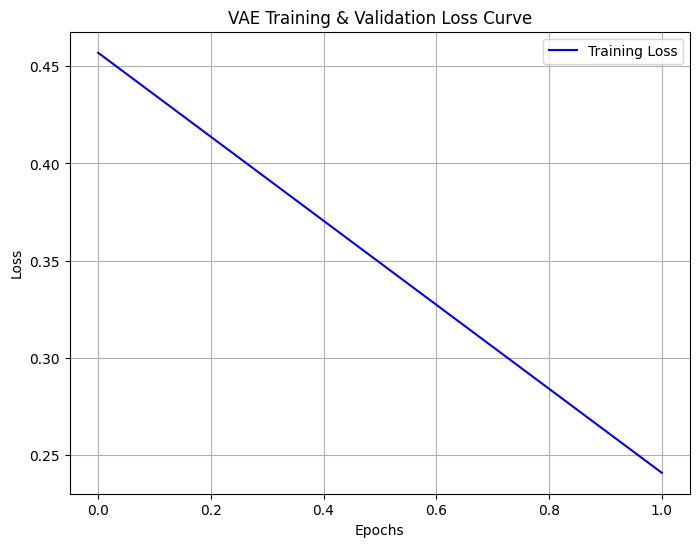

In [ ]:
reload(utils)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
#input_dim = 42
epochs = 2
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-03
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "None" # None, B_VAE, TC, B_TCVAE
patience = 5  

# IMPORTANT 
latent_dim= 5  
beta = 1 # 20
beta_tc = 0 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

time = datetime.now().strftime("%H-%M")
model_name ="LSTM_VAE"
model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
#analyze_latent_variance(vae,train_dataset, test_dataset)
#analyze_kl_divergence(vae, train_dataset, test_dataset)
#get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

if AD:
  reconstruction_AD = True
  latent_AD = True
  reconstruction_threshold, latent_threshold, mean_train, variance_train = get_threshold_from_train(model_path,reconstruction_AD, latent_AD)
  results, distances = anomaly_detection(vae, reconstruction_AD, latent_AD, mean_train, variance_train)
  reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time, AWS = AWS, s3=s3, BUCKET = BUCKET)

**Test Saved Model**

In [ ]:
#best_model_path = "/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_LSTM_VAE_LD30_Beta25_NT800000_21-37.keras"
#loaded_vae = keras.models.load_model("/Users/SCHUGD/Desktop/MasterThesis/Code/Models/Iter_BEST_BEST_VAE_11-15.keras")
loaded_vae = keras.models.load_model(model_path)
loaded_vae.trainable = False  # Freeze model weights

get_latent_representations_label(loaded_vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'TSNE', save = False)

**HyperParamter Search**

In [ ]:
reload(utils)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
#input_dim = 42
epochs = 100
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE
patience = 5  

# IMPORTANT 
latent_dim= 2  
beta = 1 # 20
beta_tc = 0 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)

# Hyperparameter search space
latent_dims = [6,9,25,14]  # Example values for latent dimension
beta_values = [3,15,7]


# Iterate over all combinations
for latent_dim, beta in itertools.product(latent_dims, beta_values):
    time = datetime.now().strftime("%H-%M")
    model_name ="BASE_LSTM_VAE"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

    print(f"Training with: latent_dim={latent_dim}, beta={beta} validation_method={validation_method}")

    vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_weakGen = VAE_weakGenerator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_2x = VAE_2x(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    VAE_2x_weakGen = VAE_2x_weak_generator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

    #optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    optimizer_weakGen = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    optimizer_2x = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    optimizer_2x_weakGen = tf.keras.optimizers.AdamW(learning_rate=learning_rate)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

    print("VAE--------------")
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae, optimizer
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE WEAK GENERATOR-------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_weakGen = train_model(vae_weakGen,optimizer_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    print("-----------------------------------------------")
    
    del vae_weakGen, optimizer_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X----------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_2x = train_model(vae_2x,optimizer_2x,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_2x, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae_2x, optimizer_2x
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X WEAK GENERATOR------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, VAE_2x_weakGen = train_model(VAE_2x_weakGen,optimizer_2x_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

   
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(VAE_2x_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type='TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del VAE_2x_weakGen, optimizer_2x_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')


**Iterative Training on Saved Model**

In [ ]:
# Regular HYPERPARAMETERS 
#input_dim = np.size(processeddataframe['features'][0])
input_dim = 42
epochs = 50
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 30  
beta = 0 # 20
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

time = datetime.now().strftime("%H-%M")
model_name ="BEST_VAE"
new_model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/Iter_BEST_{model_name}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


vae = keras.models.load_model(best_model_path)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
#optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=weight_decay)
optimizer = vae.optimizer
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path = new_model_path)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time, show_val= show_val)
#analyze_latent_variance(vae,train_dataset, test_dataset)
#analyze_kl_divergence(vae, train_dataset, test_dataset)
#get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'TSNE', save = True)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

if AD:
  reconstruction_AD = False
  latent_AD = True
  reconstruction_threshold, latent_threshold, mean_train, variance_train = get_threshold_from_train(model_path, reconstruction_AD, latent_AD)
  results, distances = anomaly_detection(vae, reconstruction_AD, latent_AD, mean_train, variance_train)
  reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time)